# Support Vector Regression (SVR)

http://mcminis1.github.io/blog/2014/05/10/intuition-for-SVR/

## Brief introduction to SVR and GP

Support vector regression (SVR) is a fast and accurate way of interpolating data sets. It is useful when you have an expensive function you want to approximate over a known domain. It learns quickly and is systematically improvable.

Variants of SVR are used throughout science including Krigging and Gaussian processes (GP).

Support vector regression is a generalization of the support vector machine to the regression problem. Technically, it can be labelled as a supervised learning algorithm. It requires a training set, \(\mathcal{T} = \{ \vec{X}, \vec{Y} \}\) which covers the domain of interest and is accompanied by solutions on that domain. 

The work of the SVM is to approximate the function we used to generate the training set, \[ F(\vec{X}) = \vec{Y}\]. 

In my mind, it's just an interpolation scheme.

In a classification problem, the vectors \(\vec{X}\) are used to define a hyperplane that seperates the two different classes in your solution. In SVR, these vectors are used to perform linear regression. The vectors closest to your test point, or decision boundary are the ones we refer to as support vectors. For regression, it turns out that all of the vectors are support vectors. We can evaluate our function anywhere, so any vectors could be closest to our test evaluation location.

Gaussian processes are a particular form of SVM. The difference between the two lies in choice of kernel and in loss function. The functional form of the kernel determines which vectors in your training set most strongly influence the regression and the form of your estimator. The loss function choice determines the coefficients used in regression. Together these two pieces totally determine the form and accuracy of your estimator. Although this makes it sound like the two are totally different, the spirit of the two are identical. Hopefully, that point will come across as I go over the specifics of them both.

## How do you build a SVR?

All right. Let's get right to the point and define how you would go about building a SVR. To build a SVR you must perform 4 tasks,

- 1 - Collect a training set, \(\mathcal{T} = \{ \vec{X}, \vec{Y} \}\).
- 2 - Choose a kernel and it's parameters as well as any regularization you may need.
- 3 - Form the correlation matrix, \(\bar{K}\).
- 4 - Train your machine, exactly or approximately, to get contraction coefficients, \(\vec{\alpha} = \{ \alpha_i \}\).
- 5 - Using those coefficients, create your estimator, \(f(\vec{X},\vec{\alpha},x^\star) = y^\star\).

Sounds like a lot of work? It's not! Just wait till you see the code in our next installment. For now, let's take each of these steps and talk a little bit about what they are doing.

## The training set

Your training set consists of the samples you've collected to train your machine. 

They should span the domain you are expecting to evaluate later. 

The SVR is only able to interpolate in between data that exists in your training set. 

For instance, if you are using your SVR machine to estimate the cosine function, you should train it on the domain \(0 \rightarrow 2\pi\) (and shift your evaluations into that range). 

When you evaluate the SVR machine outside the domain you evaluate the result will vary depending on your choice of kernel and optimization routine.

## Choosing a kernel

You are free to choose whatever kernel you would like. In this post and the following example I'll focus on using the Gaussian kernel, \[ K_G(\vec{x^i},\vec{x^j},\vec{\theta}) = \exp{\left( \sum_k^{N_{D}} \theta_k\left|x_k^i - x_k^j\right|^2 \right)}\] where \(N_D\) is the number of dimensions in each data point \(\vec{x}\) and the vector \(\vec{\theta}\) is a set of hyperparameters. Some other common choices of kernel are polynomial, Laplacian, sigmoid, and radial basis functions. All of these functions have a set of hyperparameters that must be trained.

In the gaussian process framework, the statistical interpretation of these parameters are somewhat complicated, but totally worth checking out. I refer you to one of my favorite papers on the subject, "Bi-fidelity fitting and optimization", if you can get behind the paywall. Otherwise a pretty decent source can be found at "Gaussian Processes for Machine Learning". In short, they are chosen such that they maximize the marginal probability of the training set being generated using the kernel as the Bayesian prior. This is because the loss function we use in the hyperparameter optimization step is the log probability of the parameters.

This training is the most expensive part of performing SVR, and much research has gone into developing good ways to do it. We can train it straightforwardly, if expensively, using CG or another gradient based optimization method and minimizing the cost function. The explicit form of the cost function can be found in equation 5.8 in "Gaussian Processes for Machine Learning". Other forms of SVM will use different cost functions and parameter selection routines.

## Does the kernel matter?

Yes! If you choose a kernel that goes to zero as the distance between it's arguments grows, such as the Gaussian above, \(K_G(0,\infty)=0\), then as you move away from your training data, the machine will return the mean value of your training set. If you choose a function that grows larger, such as linear or polynomial, the value will also grow linearly or polynomially. Your choice of kernel will determine the asymptotic behavior of your estimator. Choose your kernel appropriately for your problem.

## Does the regularization matter?

Yes! For training sets with some noise, the regularizer helps prevent wild fluctuations between data points by smoothing out the prior. 
You can think of this process as adding some slack to the machine. 
Regularization is achieved by adding a small positive component to the diagonal of the correlation matrix.

## Forming the correlation matrix

Forming this matrix is straightforward and really doesn't require any discussion. You evaluate your kernel for all pairs of points in the training set and then add your regularizer to the diagonal. This results in the matrix, \[ K_{i,j} = \exp{\left( \sum_k \theta_k\left|x_k^i - x_k^j\right|^2 \right)} + \epsilon \delta_{i,j}\] where \(\epsilon\) is your regularizer and \(\delta_{i,j}\) is the kroeniker delta function. This matrix is symmetric positive definite (semi-definite in the numerical sense) and easy to work with. It represents the correlation matrix of the data in a higher dimensional space than the one your training set is drawn from.

## Solve the matrix to form your estimator

This is the meat of the algorithm. Fortunately, it's all just linear algebra. Your machine works like this, \[ \bar{K} \vec{\alpha} = \vec{y} \] where \(\vec{y}\) is the vector of values corresponding to your training set, \(\bar{K}\) is still your correlation matrix, and \(\vec{\alpha}\) is a set of unknowns we need to solve for. Doing so is simple, we just invert the matrix \(\bar{K}\) and apply it to the vector, \(\vec{y}\), \[ \vec{\alpha} = \bar{K}^{-1}\vec{y}. \] Because our correlation matrix is so well behaved, efficient methods for inversion can be used (QR/Cholesky).

## Forming the estimator

Once your \(\vec{\alpha}\) parameters are known, forming the estimator is straightforward. We use the coefficients we found during the optimization step and the kernel we started off with. To estimate the value, \(y^\star\), for a test point, \(\vec{x}^\star\), we simply compute the correlation vector, \(\vec{k}\), and find the inner product with the alpha vector, \[ y^\star = \vec{\alpha}\cdot\vec{k} \] where we compute the elements of \(\vec{k}\) as, \[ k_i = \exp{\left( \sum_k \theta_k\left|x_k^i - x_k^\star\right|^2 \right)}.\]

You can see from the previous equation, if our regularizer is zero and we've inverted our matrix exactly, then the estimator perfectly passes though all of our training points. That is because the vector \(\vec{k}\) is identical to a row in the correlation matrix if the test point is in the training set! Once the regularizer is included or we have gotten our parameters using something quick but approximate, we don't recover our training set solutions, but htey should be close.


## Dirty tricks

You may notice that I have implicitly removed the mean value from my training set data. You add the mean value from the training set back into the estimator when you're done, \[ y^\star = \vec{\alpha}\cdot\vec{k} + \mu \] where \(\mu = \bar{y}\) and all \(y\) are recentered, \(y\rightarrow y-\bar{y}\). This makes it easier for the algorithm to interpolate the differences between the data points in your trinaing set instead of working very hard to also reproduce the mean.

In practice, you also want to scale your inputs so they all have the same range. The reason for this trick is the same as for any other machine that requires some nonlinear optimization. You're trying to make the minimum for your cost function as smooth and harmonic looking as possible.

## What is the SVR really?

So, now that I've taken all this time to tell you how a SVR machine, and in particular Gaussian process machine, is built, I owe you an intuitive explanation of what it is doing. It's not an easy task, so bear with me for a bit and I hope it will pay off.

The SVR performs linear regression in a higher (infinite) dimensional space. A simple way to think of it is as if each data point in your training set represents it's own dimension. When you evaluate your kernel between a test point and a point in your training set, the resulting value gives you the coordinate of your test point in that dimension. The vector we get when we evaluate the test point for all points in the training set, \(\vec{k}\), is the representation of the test point in the higher dimensional space. The form of the kernel tells you about the geometry of that higher dimensional space.

Once you have that vector, you use it to perform a linear regression. You can tell it is a linear regression because of the form of the estimator, it's an inner product! Thus the intuition for the machine is rather simple, though the procedure and parameters may be difficult to interpret.

## So, what's the SVR good for?

Because you are able to generate training points, you know what the "right" answer is. However, it may be very expensive to compute that answer for every new point you need. The SVR, and in particular Gaussian processes, are very good at providing a cheap surrogate to an expensive call. If the function you are trying to compute is smooth, and you expect to have to call it over and over again, you may be able to gain a significant savings by pre-computing a training set and then using a SVR machine to interpolate the results.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

dataset = pd.read_csv('Position_Salaries.csv')

plt.scatter(dataset['Level'], dataset['Salary'])
plt.show() 

dataset

,Position,Level,Salary
0,Business Analyst,1,45000
1,Junior Consultant,2,50000
2,Senior Consultant,3,60000
3,Manager,4,80000
4,Country Manager,5,110000
5,Region Manager,6,150000
6,Partner,7,200000
7,Senior Partner,8,300000
8,C-level,9,500000
9,CEO,10,1000000


In [2]:
X = dataset.iloc[:, 1:2].values
y = dataset.iloc[:, 2].values

X,y

(array([[ 1],
        [ 2],
        [ 3],
        [ 4],
        [ 5],
        [ 6],
        [ 7],
        [ 8],
        [ 9],
        [10]], dtype=int64),
 array([  45000,   50000,   60000,   80000,  110000,  150000,  200000,
         300000,  500000, 1000000], dtype=int64))

In [3]:
# Fitting SVR to the dataset
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(X, y)

# Predicting a new result
y_pred = regressor.predict(6.5)

y_pred[0]

130001.55760156453

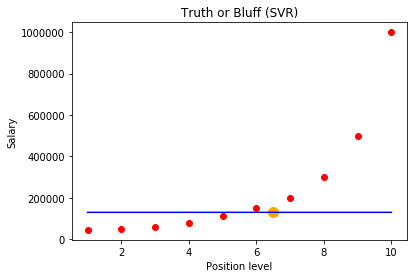

In [4]:
# Visualising the SVR results
plt.scatter(X, y, color = 'red')
plt.plot(X, regressor.predict(X), color = 'blue')
plt.scatter(6.5,y_pred, s=100, color = 'orange')
plt.title('Truth or Bluff (SVR)')
plt.xlabel('Position level')
plt.ylabel('Salary')
plt.show()

We see that everything went badly with this svr model , its because we missed feature scaling 

In [5]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)
y

c:\users\yanni iyeze\appdata\local\programs\python\python36-32\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


ValueError: Expected 2D array, got 1D array instead:
array=[   45000.    50000.    60000.    80000.   110000.   150000.   200000.
   300000.   500000.  1000000.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [ ]:
# Fitting SVR to the dataset
from sklearn.svm import SVR
regressor = SVR(kernel = 'rbf')
regressor.fit(X, y)

# Predicting a new result
y_pred = sc_y.inverse_transform(regressor.predict(sc_X.fit_transform(np.array([[6.5]]))))

y_pred

In [ ]:
# Visualising the SVR results
plt.scatter(X, y, color = 'red')
plt.plot(X, regressor.predict(X), color = 'blue')
plt.title('Truth or Bluff (SVR)')
plt.xlabel('Position level')
plt.ylabel('Salary')
plt.show()